## Cluster-based Local Outlier Factor (CBLOF)
* It defiens anomalies as a combination of Local Distances to nearby clusters, and the size of the clusters to which the data point belongs.
* It uses a clustering approach: K-NN
* Then, it uses also the size of the clusters.
* With these 2 metrics, it infers outliers as:
- - Any data point of a small cluster next to a nearby larger cluster.


### Prepare the data set

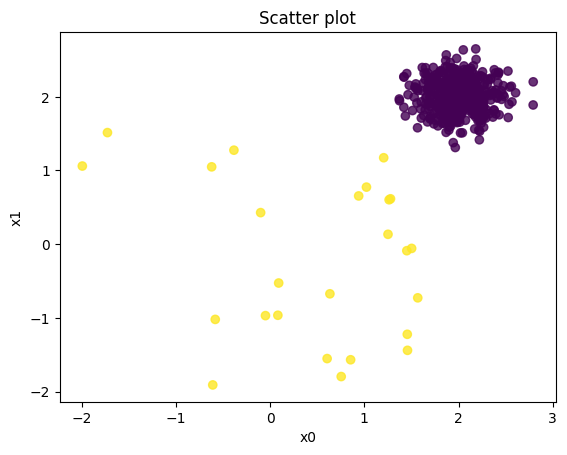

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_od import count_stat, confusion_matrix, confusion_matrix_threshold,plot_data ,descriptive_stat_threshold 
from pyod.utils.data import generate_data

contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Build the model
* Steps:
1. Assigns a data point to one and only one cluster. Use KNN clustering for this task.
2. Rank clusters according to cluster size from large to small and get the cumulative data counts.
- - Those clusters that hold up to 90% ( changable threshold ) of the data are called "large".
3. Calculates the distance of a data point to the centroid and the outlier score according to the following rule:
- - if a data point belongs to a larger cluster, the distance is the distance towards the centroid of the same cluster.
- - if a data point belongs to a small cluster, the distance is the distance towards the local kth nearest neighborhood.

In [2]:
from pyod.models.cblof import CBLOF
cblof = CBLOF(n_clusters=10, contamination = 0.05) 
cblof.fit(X_train)

# Training data
y_train_scores = cblof.decision_function(X_train)
y_train_pred = cblof.predict(X_train)

# Test data
y_test_scores = cblof.decision_function(X_test)
y_test_pred = cblof.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , cblof.threshold_)

/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}
The threshold for the defined contamination rate: 1.0995823998499585


### Understand the parameters
* alpha: Count percentage of the large clusters. Threshold that determines what is a large/small cluster in %.
* beta: Coefficient to decide small and large clusters. Cluster k-1 will have to be beta times smaller than cluster k. Then, for cluster k-1, cluser k would be the closest larger.

In [3]:
cblof.get_params()

{'alpha': 0.9,
 'beta': 5,
 'check_estimator': False,
 'clustering_estimator': None,
 'contamination': 0.05,
 'n_clusters': 10,
 'n_jobs': None,
 'random_state': None,
 'use_weights': False}

### Determine the threshold

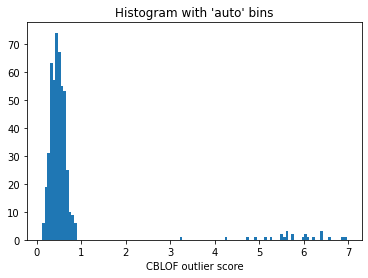

In [24]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('CBLOF outlier score')
plt.show()

### Descriptive statistics
* Check if features means and outlier scores make sense.
* Since Anomaly Score differs considerably between normal and outlier group, the model seems to work.
* Also, values for the mean per each feature also differ considerably.

In [4]:
threshold = cblof.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,0.48
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,5.74


In [5]:
confusion_matrix_threshold(y_train, y_train_scores, cblof.threshold_)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [6]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Aggregate Model Predictions to Achieve Stability

In [7]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.cblof import CBLOF

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of clusters from 10 to 50. There will be 5 models.
n_clf = 5
k_list = [10, 20, 30, 40, 50]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    cblof = CBLOF(n_clusters = k, contamination=0.05)  
    cblof.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = cblof.decision_function(X_train_norm) 
    test_scores[:, i] = cblof.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mark/miniconda3/envs/rin/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

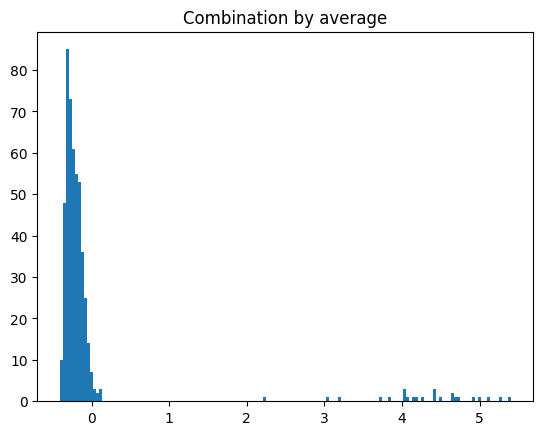

In [8]:
# Combination by average
# The test_scores_norm is 500 x 5. The "average" function will take the average of the 5 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [9]:
threshold_by_avg = 0.3
descriptive_stat_threshold(X_train,y_train_by_average, threshold_by_avg)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.23
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,4.28


In [10]:
descriptive_stat_threshold(X_test,y_test_by_average, threshold_by_avg)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.02,2.01,2.01,1.99,2.01,2.00,-0.20
1,Outlier,25,5.0,0.00,-0.54,-0.23,-0.05,-0.06,0.12,4.33


## Summary CBLOF
* It defines anomalies as a combination of local distances to nearby clusters and size of the clusters to which the data point belongs.
* First clustersd ata points into clusters, then identifies data points in small clustersfor local outliers.